In [45]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from copy import deepcopy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
0.76120.7612
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

# Set up desired datasets and parameters

In [112]:
dataset = sf_inputs_discrete.Sim2DWalk
num_steps = 2000
num_states = 100
input_size = 100
gamma = 0.8
arena_length = int(np.sqrt(num_states))

dataset_config = {
    'num_steps': num_steps, 'num_states': num_states
    }

feature_maker_configs = []

# Correlated distributed inputs
feature_maker_configs.append({
    'feature_dim': input_size, 'feature_vals': None,
    'feature_type': 'correlated_sparse',
    #'feature_vals_p': [0.8, 0.2],
    'spatial_sigma': 1.25
    })

# Run each dataset

In [132]:
for feature_maker_kwargs in feature_maker_configs:
    _dset_config = deepcopy(dataset_config)
    _dset_config['feature_maker_kwargs'] = feature_maker_kwargs
    input = dataset(**_dset_config)
    walk_xs = input.xs.astype(int)
    walk_ys = input.ys.astype(int)
    rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 5E-3, 'parameterize': False,
        'alpha': 1., 'beta': 1.
        }
    )
    outputs, loss, dset = run_rnn(
        '../trained_models/test/', rnn, dataset,
        _dset_config, gamma=gamma, train_net=False, return_dset=True
        )


[   51] loss: 0.027
Time per step 0.003s, net 0.136s

[  101] loss: 0.026
Time per step 0.004s, net 0.320s

[  151] loss: 0.024
Time per step 0.004s, net 0.545s

[  201] loss: 0.024
Time per step 0.006s, net 0.821s

[  251] loss: 0.023
Time per step 0.006s, net 1.129s

[  301] loss: 0.023
Time per step 0.007s, net 1.478s

[  351] loss: 0.024
Time per step 0.008s, net 1.889s

[  401] loss: 0.026
Time per step 0.009s, net 2.341s

[  451] loss: 0.026
Time per step 0.012s, net 2.924s

[  501] loss: 0.028
Time per step 0.012s, net 3.541s

[  551] loss: 0.028
Time per step 0.012s, net 4.122s

[  601] loss: 0.028
Time per step 0.012s, net 4.742s

[  651] loss: 0.029
Time per step 0.014s, net 5.424s

[  701] loss: 0.030
Time per step 0.015s, net 6.171s

[  751] loss: 0.031
Time per step 0.017s, net 7.016s

[  801] loss: 0.033
Time per step 0.019s, net 7.956s

[  851] loss: 0.035
Time per step 0.022s, net 9.032s

[  901] loss: 0.035
Time per step 0.025s, net 10.277s


KeyboardInterrupt: 

# Plot aggregate metrics
From Henrikson & Mosers, 2010: "A place field was estimated as a contiguous region of at least 225 cm2 (9 or more 5 cm × 5 cm bins) where the firing rate was above 20% of the peak rate and the peak firing rate of the area was 0.25 Hz or higher. The number of nonoverlapping place fields was estimated for each cell. "

In [123]:
walk_xs = dset.xs.astype(int)
walk_ys = dset.ys.astype(int)

In [124]:
from findpeaks import findpeaks
from scipy.ndimage.measurements import label

In [125]:
def get_area_and_peaks(firing_field):
    masked_field = firing_field > 0.8
    labeled_array, ncomponents = label(masked_field, np.ones((3,3)))
    areas = []
    for label_id in np.unique(labeled_array):
        if label_id == 0: continue
        areas.append(np.sum(labeled_array == label_id))
    return areas, ncomponents

In [126]:
def flatten_xy(walk_xs, walk_ys):
    max_col = walk_ys.max()
    new_bins = walk_xs * max_col + walk_ys
    return new_bins

def circular(fr):
    """
    Circularly shuffles a (neur, frames) array of firing rates, neuron by neuron.
    """

    fr = fr.copy()
    shift = np.random.choice(np.arange(1, fr.size))
    if len(fr.shape) == 2:
        num_neur, num_frames = fr.shape
        for neur in range(num_neur):
            shift = np.random.choice(np.arange(1, num_frames))
            fr[neur,:] = np.roll(fr[neur,:], shift)
        return fr
    else:
        return np.roll(fr, shift)
    
def get_mutual_info(conditions, fr):
    """
    Calculates mutual information between firing rate and a set of conditions

    Args:
        conditions: (frames,) array of conditions
        fr: (neurs, frames) array of firing rates
    Returns:
        (neurs,) array of scaler value mutual information per neuron
    """

    num_neurs, _ = fr.shape
    mean_fr = np.mean(fr, axis=1)
    mutual_info = np.zeros(num_neurs)
    for condn in np.unique(conditions):
        prob = np.sum(conditions==condn)/conditions.size
        condn_mean_fr = np.mean(fr[:,conditions==condn], axis=1)
        log_term = np.log2(condn_mean_fr/mean_fr)
        log_term[np.isnan(log_term)] = 0
        log_term[np.isinf(log_term)] = 0
        mutual_info += prob*condn_mean_fr*log_term
    return mutual_info

def calc_place_cells(xs, ys, fr, num_shuffles):
    """ Gets the spatial mutual information of each cell."""

    num_neurs, num_frames = fr.shape
    spatial_info = np.zeros(num_neurs)
    significance = np.zeros(num_neurs)
    conditions = flatten_xy(xs, ys)
    spatial_info = get_mutual_info(conditions, fr)
    
    for _ in range(num_shuffles):
        shuffled_fr = circular(fr)
        shuffled_info = get_mutual_info(conditions, shuffled_fr)
        significance += (shuffled_info < spatial_info)
    significance /= num_shuffles
    
    return spatial_info, significance

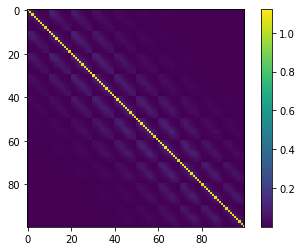

In [127]:
M = rnn.get_M().detach().numpy()
plt.figure()
plt.imshow(M)
plt.colorbar()
plt.show()

[4]
1
0.2329901800674179
1.0


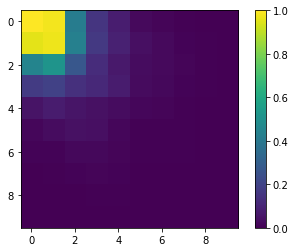


[4]
1
0.242974387511822
1.0


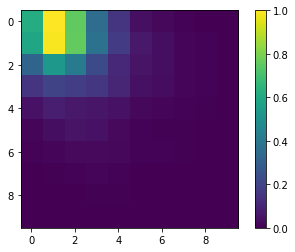


[6]
1
0.2347741594976469
1.0


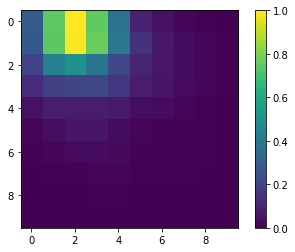


[6]
1
0.19829579608995118
1.0


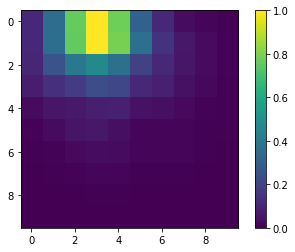


[6]
1
0.16925150217275586
1.0


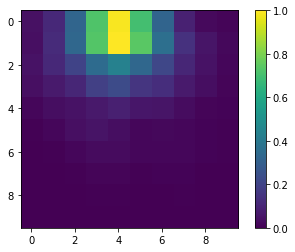


[6]
1
0.1638042804388533
1.0


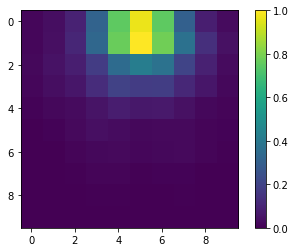


[6]
1
0.1649336468221918
1.0


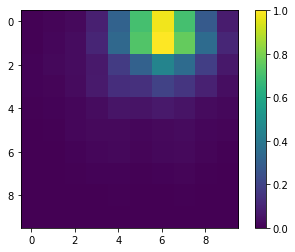


[5]
1
0.16491450228295434
1.0


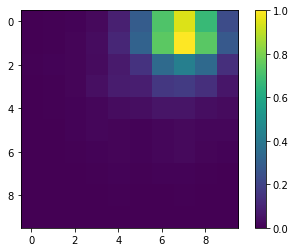


[3]
1
0.15134498514225925
1.0


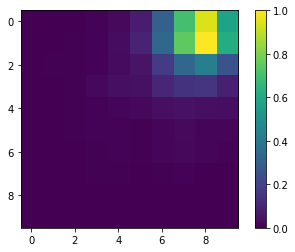


[4]
1
0.12875205295677006
1.0


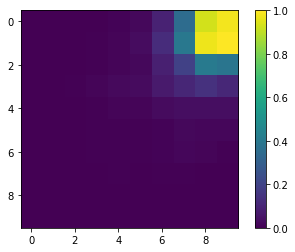


[4]
1
0.24630023774875553
1.0


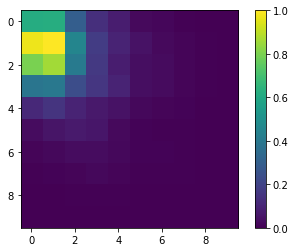


[5]
1
0.2616559907662577
1.0


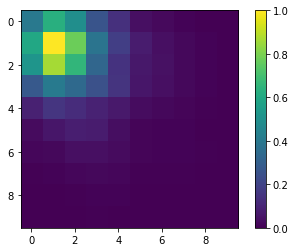


[7]
1
0.26131261126829486
1.0


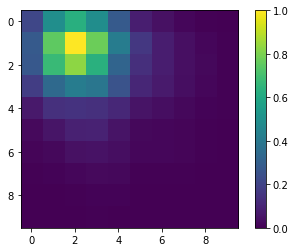


[5]
1
0.23176078980668535
1.0


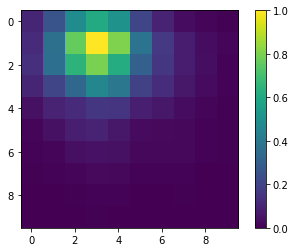


[4]
1
0.20680896135675653
1.0


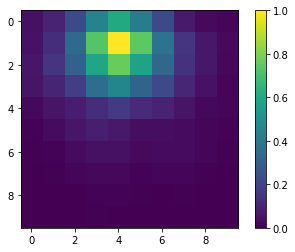


[4]
1
0.19765465782165847
1.0


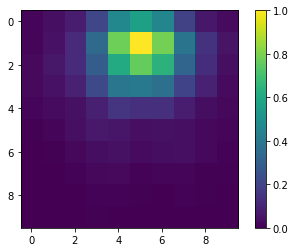


[4]
1
0.19183711834466521
1.0


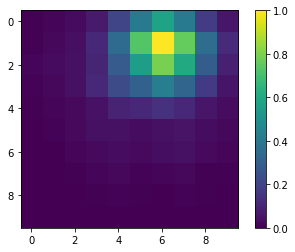


[4]
1
0.19032811641045555
1.0


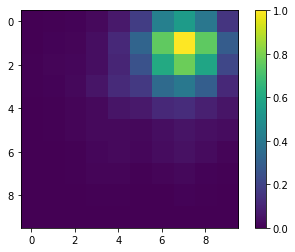


[3]
1
0.17989031249544496
1.0


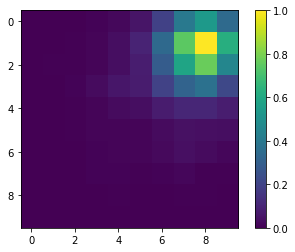


[4]
1
0.1611732402184316
1.0


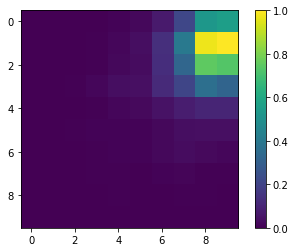


[6]
1
0.2417780916002812
1.0


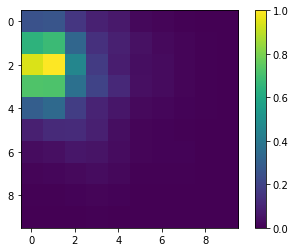


[6]
1
0.25797925619053785
1.0


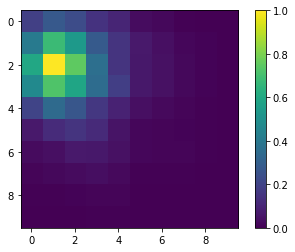


[7]
1
0.2606119632891932
1.0


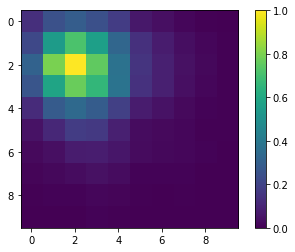


[8]
1
0.24085855457633443
1.0


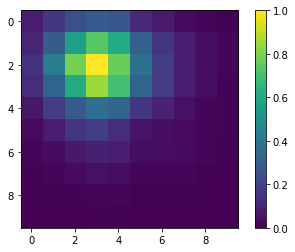


[7]
1
0.22828996567568538
1.0


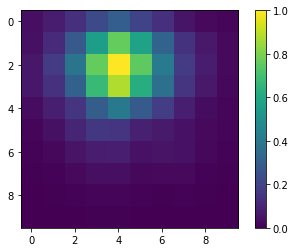


[7]
1
0.22267071592250431
1.0


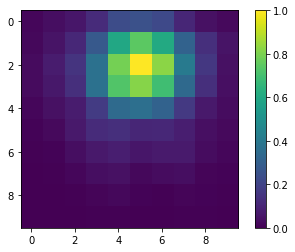


[5]
1
0.21488845339445106
1.0


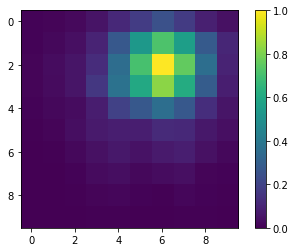


[6]
1
0.21424083960482676
1.0


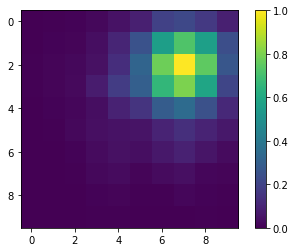


[4]
1
0.20861693077858945
1.0


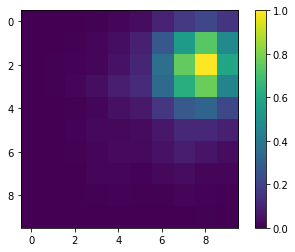


[6]
1
0.19600278505185997
1.0


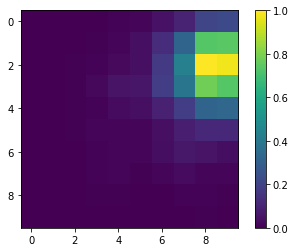


[6]
1
0.20855689367181185
1.0


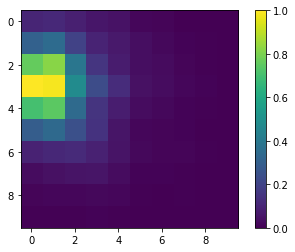


[6]
1
0.22510173224327445
1.0


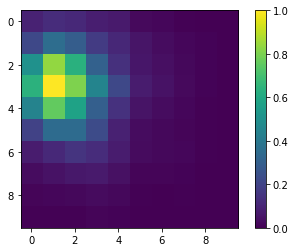


[6]
1
0.22991297500266228
1.0


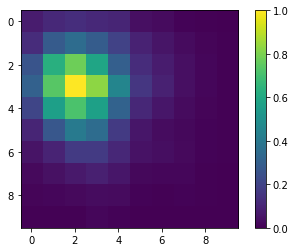


[7]
1
0.21658754706641048
1.0


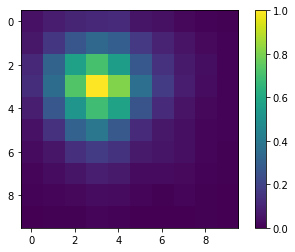


[5]
1
0.21070767577475635
1.0


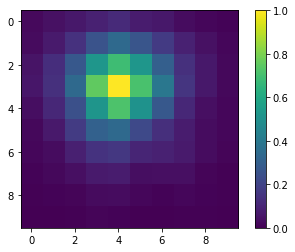


[7]
1
0.21172666730308265
1.0


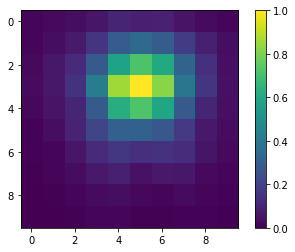


[5]
1
0.20972906555653026
1.0


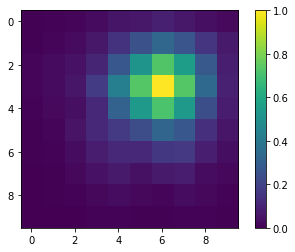


[5]
1
0.21017412682158465
1.0


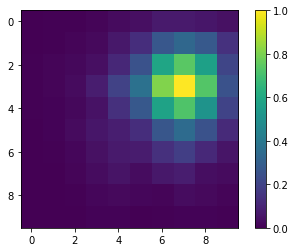


[4]
1
0.20468154168156616
1.0


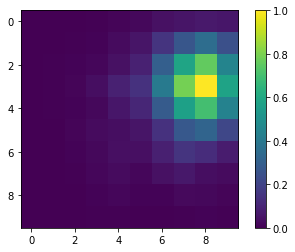


[6]
1
0.1948162443259207
1.0


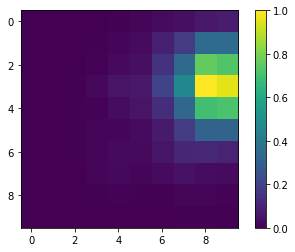


[6]
1
0.18300423517484887
1.0


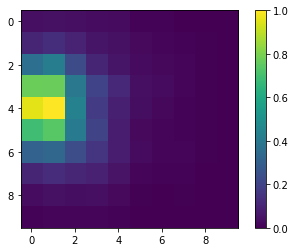


[6]
1
0.20578895346079662
1.0


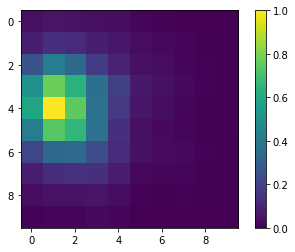


[7]
1
0.21965229388843
1.0


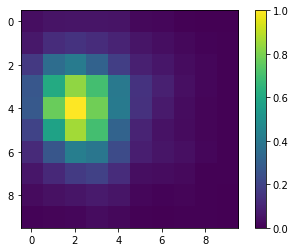


[8]
1
0.2074998325751949
1.0


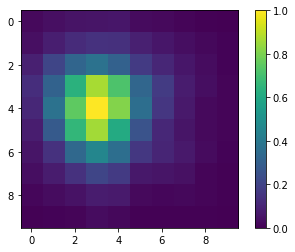


[8]
1
0.19767494316693046
1.0


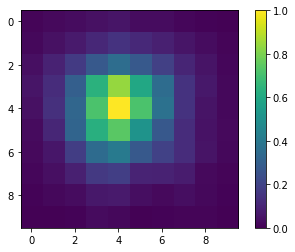


[8]
1
0.20930470828534453
1.0


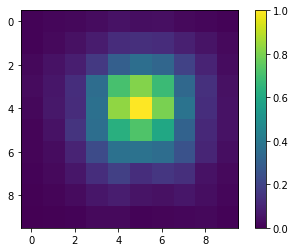


[7]
1
0.21797815992158576
1.0


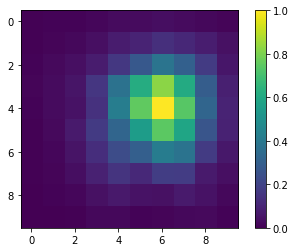


[6]
1
0.20653151669102954
1.0


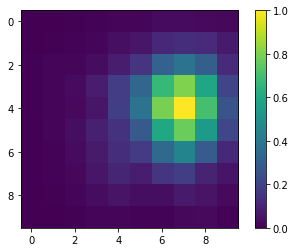


[4]
1
0.18045294250987354
1.0


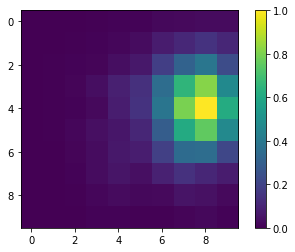


[6]
1
0.16087824847181764
1.0


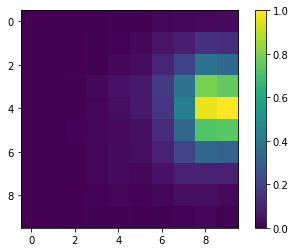


[6]
1
0.17984321941457893
1.0


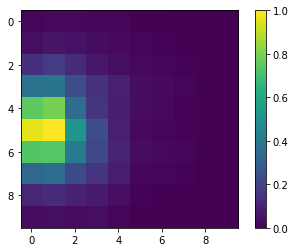


[5]
1
0.20870922836638783
1.0


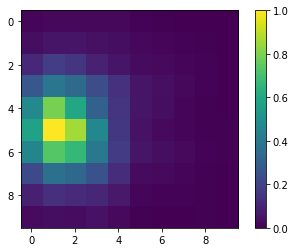


[6]
1
0.2309110985534062
1.0


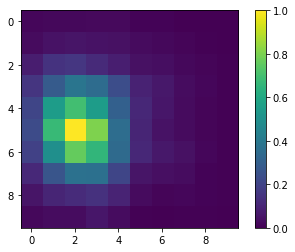


[8]
1
0.21672122576637776
1.0


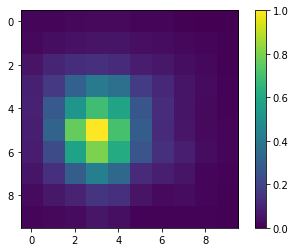


[6]
1
0.2028428356970835
1.0


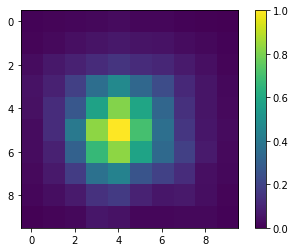


[9]
1
0.22821058118279325
1.0


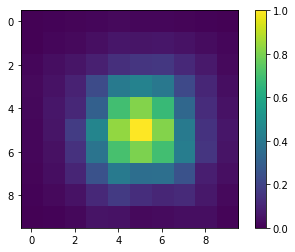


[8]
1
0.24783624595147558
1.0


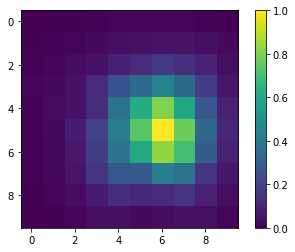


[7]
1
0.22062799956211165
1.0


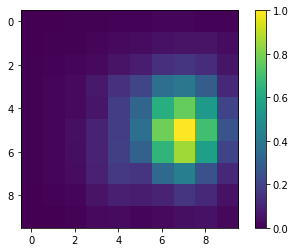


[4]
1
0.16580052597782924
1.0


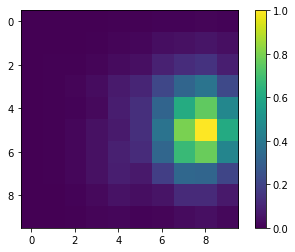


[6]
1
0.12796168276690878
1.0


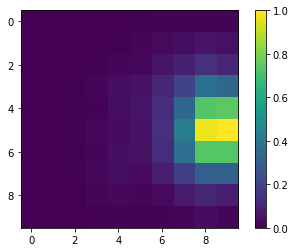


[6]
1
0.19605231760488095
1.0


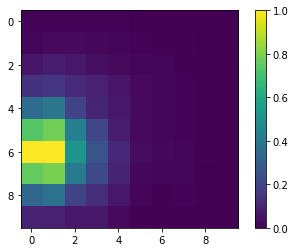


[6]
1
0.2255692878170521
1.0


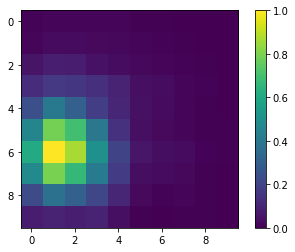


[7]
1
0.24546721163096663
1.0


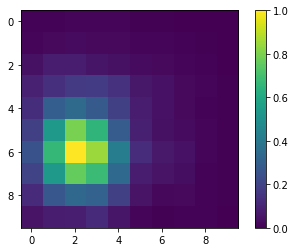


[7]
1
0.2247064126568148
1.0


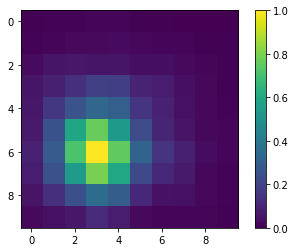


[7]
1
0.20872199660152546
1.0


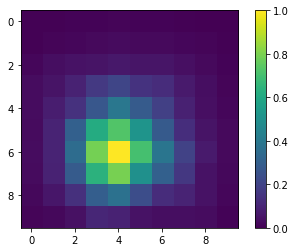


[9]
1
0.23837481224472867
1.0


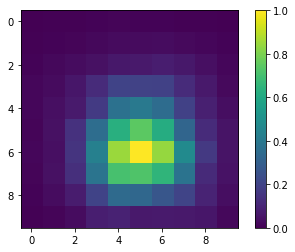


[7]
1
0.2596154718339676
1.0


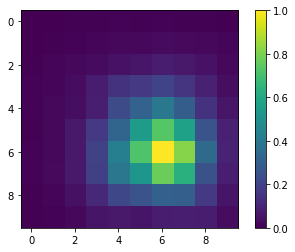


[6]
1
0.23007199737912742
1.0


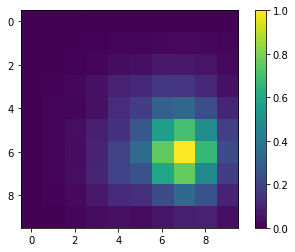


[4]
1
0.1670801515729181
1.0


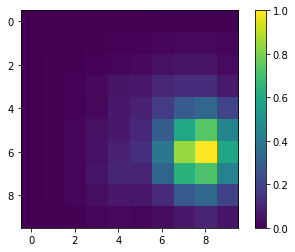


[4]
1
0.11961634637555107
1.0


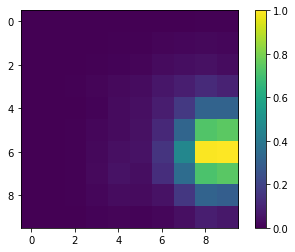


[6]
1
0.21382018531494396
1.0


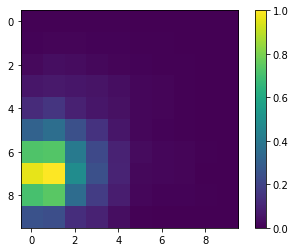


[5]
1
0.2414573062933414
1.0


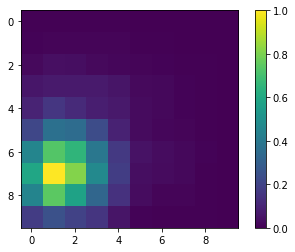


[6]
1
0.2508571972994105
1.0


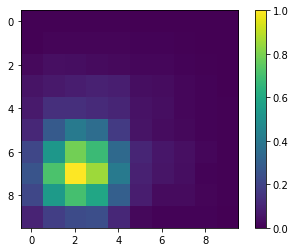


[6]
1
0.2218870381875604
1.0


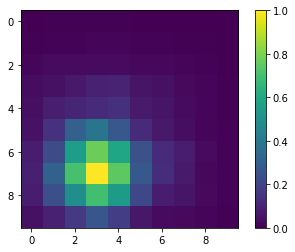


[6]
1
0.20877968554123072
1.0


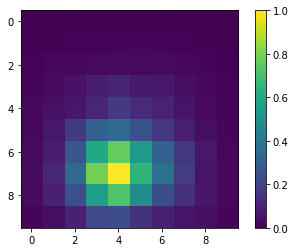


[8]
1
0.23762244187673787
1.0


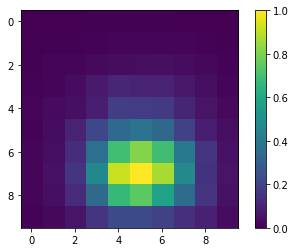


[6]
1
0.2542138604185311
1.0


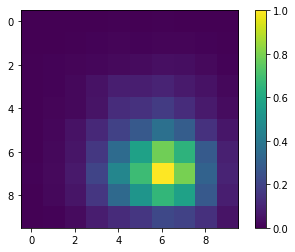


[6]
1
0.22796734879011638
1.0


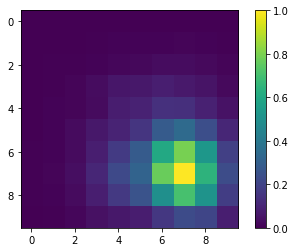


[4]
1
0.16954729109238542
1.0


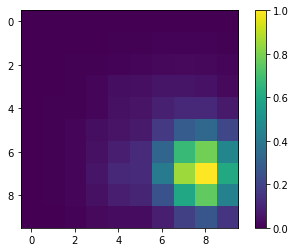


[4]
1
0.121562468168122
1.0


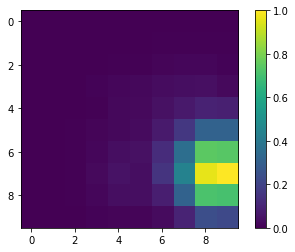


[4]
1
0.19969306558186872
1.0


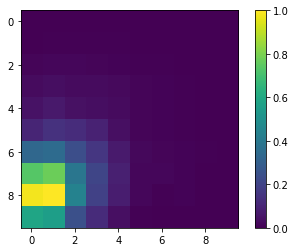


[4]
1
0.22477946851176966
1.0


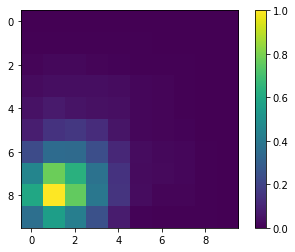


[5]
1
0.22674262303189607
1.0


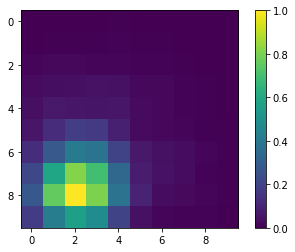


[4]
1
0.2007777651347169
1.0


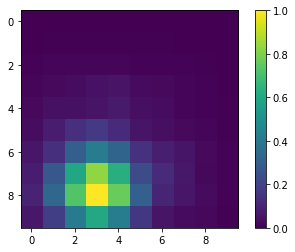


[5]
1
0.2003173078846885
1.0


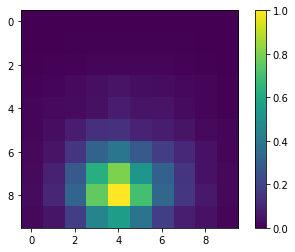


[6]
1
0.2288868819232448
1.0


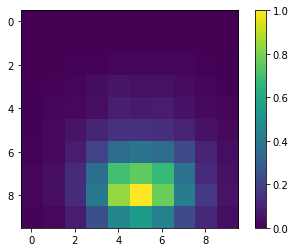


[5]
1
0.2386540199513547
1.0


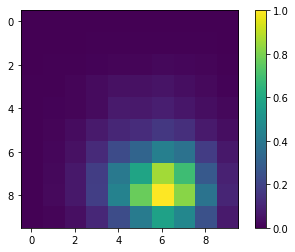


[4]
1
0.21018122688110452
1.0


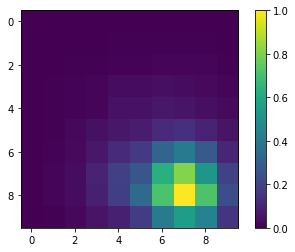


[3]
1
0.15326453016677988
1.0


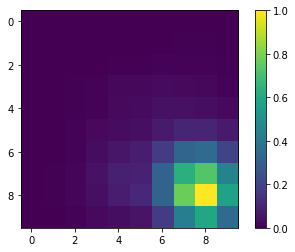


[3]
1
0.1074507756256935
1.0


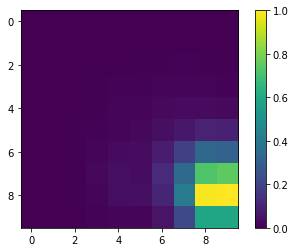


[4]
1
0.1702514171497569
1.0


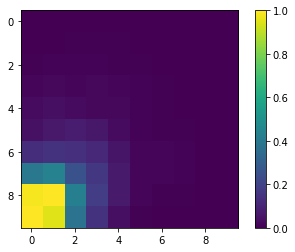


[4]
1
0.1930928279980435
1.0


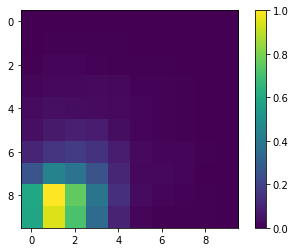


[6]
1
0.19355499110679375
1.0


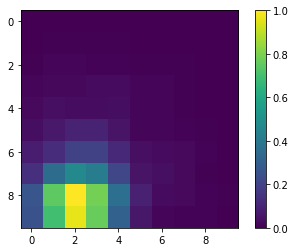


[6]
1
0.17714181571136578
1.0


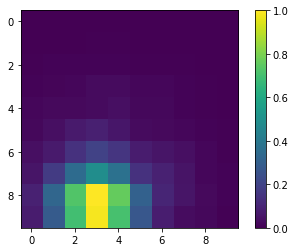


[5]
1
0.18743966382135113
1.0


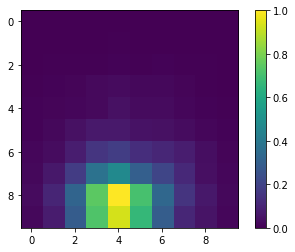


[6]
1
0.21259170155099127
1.0


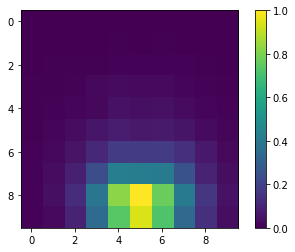


[6]
1
0.21574697067808302
1.0


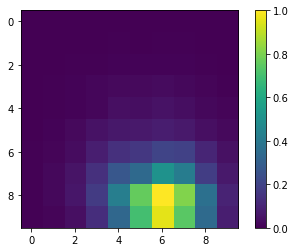


[6]
1
0.184894260526562
1.0


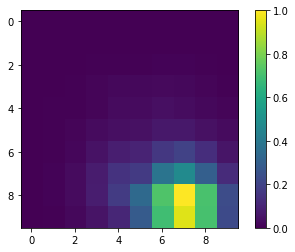


[3]
1
0.13066252266435185
1.0


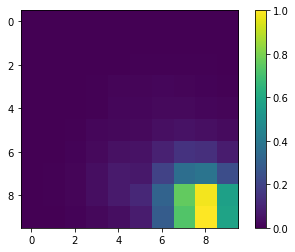


[4]
1
0.08896042031938123
1.0


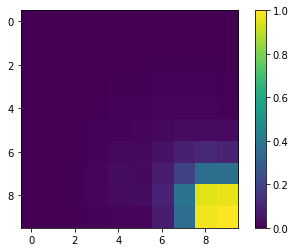

In [128]:
all_areas = []
all_ncomps = []

spatial_info, significance = calc_place_cells(
    walk_xs, walk_ys, outputs.T, 100
    )

for neur in np.arange(outputs.shape[1]):
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0
    
    # Area?
    area, ncomponents = get_area_and_peaks(firing_field)
    print(area)
    print(ncomponents)
    print(spatial_info[neur])
    print(significance[neur])
    all_areas.append(np.sum(area))
    all_ncomps.append(ncomponents)
    
    plt.figure();
    plt.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    
    print()

In [129]:
np.mean(all_areas)/num_states

0.0557

In [130]:
np.mean(all_ncomps)

1.0